Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from keras import optimizers
from glob import glob
from tensorflow.keras.preprocessing.image import load_img


In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive/')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive/


In [ ]:
# list out the directories
#!ls "/content/gdrive/MyDrive/"

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [2]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train images:\t", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test images:\t", image_count_test)

Train images:	 2239
Test images:	 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    seed=123,
    validation_split=0.2,
    subset = 'training',
    image_size=(img_height,img_width)
    )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    seed=123,
    validation_split=0.2,
    subset = 'validation',
    image_size=(img_height,img_width)
    )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
# verify the element specification
train_ds.element_spec

(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

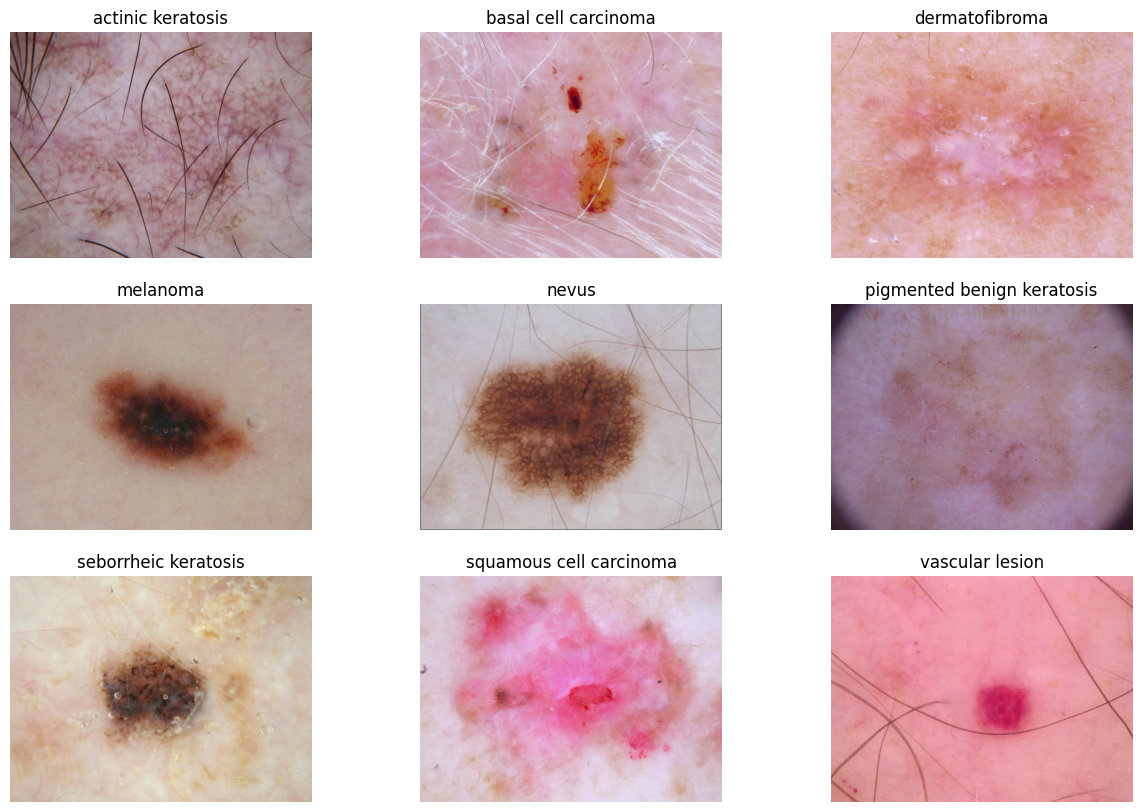

In [ ]:
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), class_)
    file_path = glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

In [ ]:
# verify the image and label shapes
for image_batch, labels_batch in train_ds.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here

# First Model
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(class_names))
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 44, 44, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 42, 64)        1

### Train the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 356s 1s/step - loss: 2.1189 - accuracy: 0.1987 - val_loss: 1.9296 - val_accuracy: 0.2752
Epoch 2/20
56/56 [==============================] - 2s 31ms/step - loss: 1.8727 - accuracy: 0.3315 - val_loss: 1.6942 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 2s 28ms/step - loss: 1.6573 - accuracy: 0.4275 - val_loss: 1.5758 - val_accuracy: 0.4497
Epoch 4/20
56/56 [==============================] - 1s 26ms/step - loss: 1.5459 - accuracy: 0.4721 - val_loss: 1.7425 - val_accuracy: 0.4206
Epoch 5/20
56/56 [==============================] - 2s 27ms/step - loss: 1.5078 - accuracy: 0.4760 - val_loss: 1.4502 - val_accuracy: 0.4966
Epoch 6/20
56/56 [==============================] - 2s 27ms/step - loss: 1.3766 - accuracy: 0.5195 - val_loss: 1.4196 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 2s 28ms/step - loss: 1.3337 - accuracy: 0.5357 - val_loss: 1.5465 - val_accuracy: 0.4698
Epoch 8/20
56

### Visualizing training results

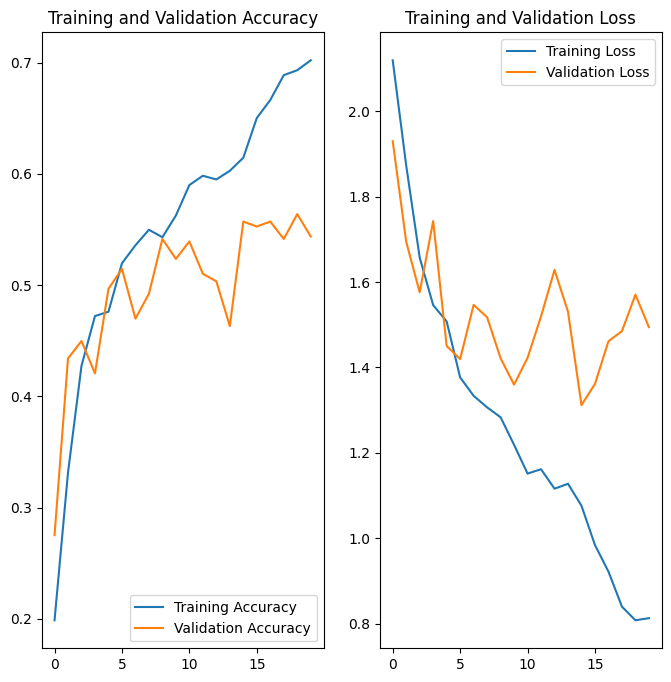

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Definitely Model overfits since Training Accuracy is higher but validation Accuracy is very low.

Model seems to learn more noise data due to less available of Training Data

Action to be taken reduce overfitting
- Add reasonable Dropout layers
- Make the architecture simple
- Get More Data for Training or use augmentation


### Write your findings here

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Data Augmentation

data_augmentaion = Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomZoom(0.1)
    ]
)

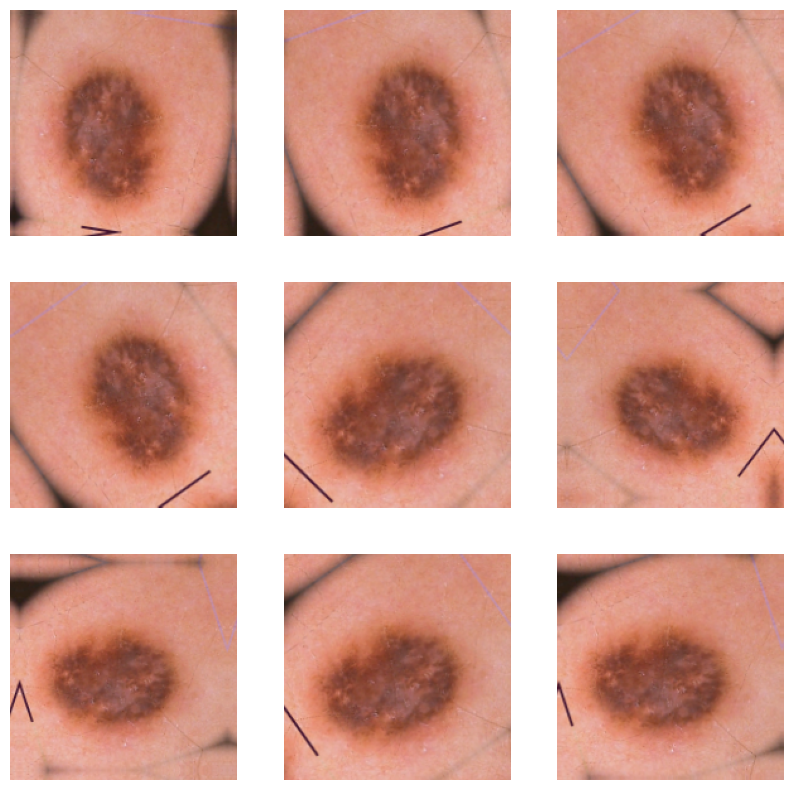

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augumented_images = data_augmentaion(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augumented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

# Second Model
model = Sequential([
    data_augmentaion,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(class_names))
])

### Compiling the model

In [ ]:
## Your code goes here
#optm = optimizers.Adam(learning_rate=0.005)
model.compile(optimizer="Adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 37ms/step - loss: 1.9809 - accuracy: 0.2974 - val_loss: 1.7524 - val_accuracy: 0.3132
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.6735 - accuracy: 0.3923 - val_loss: 1.5708 - val_accuracy: 0.4676
Epoch 3/20
56/56 [==============================] - 2s 30ms/step - loss: 1.5796 - accuracy: 0.4520 - val_loss: 1.4850 - val_accuracy: 0.5257
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5060 - accuracy: 0.4838 - val_loss: 1.4425 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4505 - accuracy: 0.5011 - val_loss: 1.4168 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3867 - accuracy: 0.4961 - val_loss: 1.3621 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.3407 - accuracy: 0.5240 - val_loss: 1.4503 - val_accuracy: 0.5548
Epoch 8/20
56

### Visualizing the results

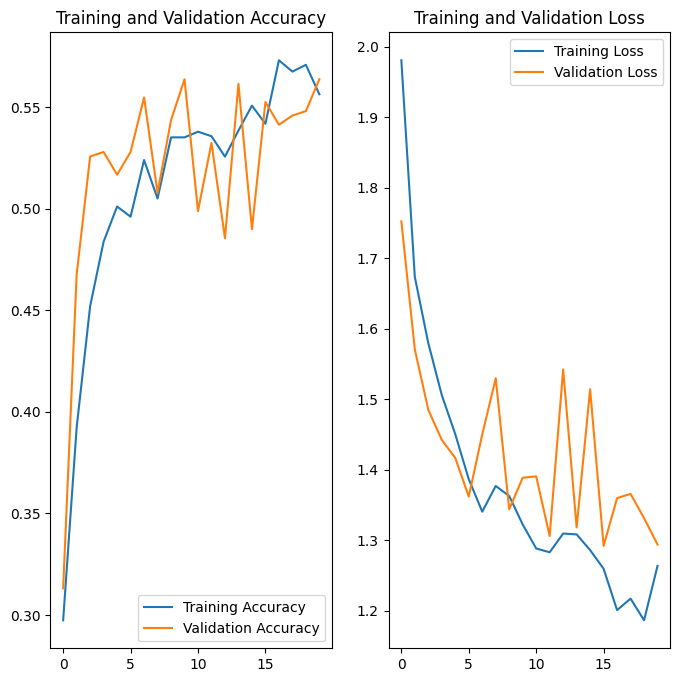

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### After the augmentation the model underfit. Eventhough training accuracy got lower compare to the previous model, it is failed to catch the complex pattern.

### Deep learning requires more data to train to get the high accuracy

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
# count the images group by class names
class_size={}
for name in class_names:
  class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

In [ ]:
## Your code goes here.
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [ ]:
# count of images using DataFrame
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df["Label"].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?

#### <font color="green">seborrheic keratosis has the least number of samples </font>

#### - Which classes dominate the data in terms proportionate number of samples?

#### <font color="green">pigmented benign keratosis has the domination </green>

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset = "gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA7AD22FF70>: 100%|██████████| 500/500 [00:18<00:00, 27.04 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA7AD24EF80>: 100%|██████████| 500/500 [00:17<00:00, 28.27 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EA7AD274190>: 100%|██████████| 500/500 [00:19<00:00, 25.97 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7EA82C1C0400>: 100%|██████████| 500/500 [01:29<00:00,  5.56 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7EA7AD2779D0>: 100%|██████████| 500/500 [01:19<00:00,  6.27 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA7AD2D3AC0>: 100%|██████████| 500/500 [00:18<00:00, 27.25 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EA82C272A10>: 100%|██████████| 500/500 [00:40<00:00, 12.25 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA7AD3C9D80>: 100%|██████████| 500/500 [00:18<00:00, 27.49 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EA7AD2747F0>: 100%|██████████| 500/500 [00:20<00:00, 24.73 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033969.jpg_97bc41a5-b0f8-4732-9990-47ef112c6789.jpg',
 'gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028714.jpg_14686407-cc62-4d70-a3a7-a951f23b0350.jpg',
 'gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031215.jpg_aecf0f8b-d38f-4b4d-9d40-140bbbeca309.jpg',
 'gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028146.jpg_8aa1d138-8673-476d-8995-9eb9120941c0.jpg',
 'gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029486.jpg_75168a43-1efb-4659-901e-a0abe2d6d8ac.jpg',
 'gdrive/MyDrive/Skin cancer ISIC T

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [ ]:
# create a new dictionary
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
# check the count before append
original_df["Label"].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [ ]:
# create a new data frame
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-50-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [ ]:
# view the data frame
original_df.head()

,Path,Label
0,gdrive/MyDrive/Skin cancer ISIC The Internatio...,vascular lesion
1,gdrive/MyDrive/Skin cancer ISIC The Internatio...,vascular lesion
2,gdrive/MyDrive/Skin cancer ISIC The Internatio...,vascular lesion
3,gdrive/MyDrive/Skin cancer ISIC The Internatio...,vascular lesion
4,gdrive/MyDrive/Skin cancer ISIC The Internatio...,vascular lesion


In [ ]:
# check the count after append
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6689 files belonging to 9 classes.
Using 5352 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6689 files belonging to 9 classes.
Using 1337 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(class_names))
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer="Adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
168/168 [==============================] - 7s 29ms/step - loss: 1.9199 - accuracy: 0.2625 - val_loss: 1.6957 - val_accuracy: 0.3538
Epoch 2/30
168/168 [==============================] - 5s 27ms/step - loss: 1.5269 - accuracy: 0.4083 - val_loss: 1.3100 - val_accuracy: 0.4757
Epoch 3/30
168/168 [==============================] - 5s 29ms/step - loss: 1.4230 - accuracy: 0.4471 - val_loss: 1.3380 - val_accuracy: 0.5026
Epoch 4/30
168/168 [==============================] - 5s 27ms/step - loss: 1.2361 - accuracy: 0.5237 - val_loss: 1.2428 - val_accuracy: 0.4936
Epoch 5/30
168/168 [==============================] - 5s 27ms/step - loss: 1.0749 - accuracy: 0.5966 - val_loss: 0.9522 - val_accuracy: 0.6387
Epoch 6/30
168/168 [==============================] - 5s 28ms/step - loss: 0.9052 - accuracy: 0.6626 - val_loss: 0.9163 - val_accuracy: 0.6552
Epoch 7/30
168/168 [==============================] - 5s 27ms/step - loss: 0.7772 - accuracy: 0.7074 - val_loss: 0.9032 - val_accuracy: 0.6552

#### **Todo:**  Visualize the model results

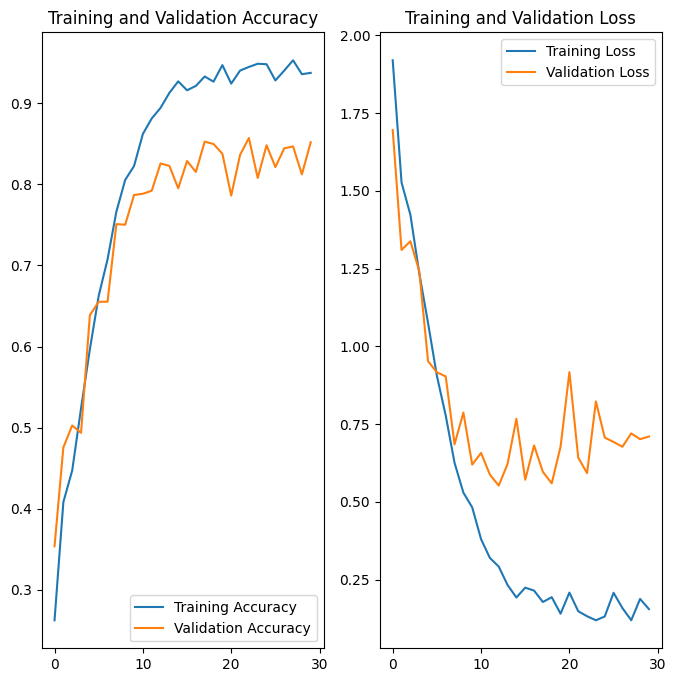

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

### Yes, the rebalnce helps improve the model Validation Accuray.

### The Training Accuracy improved to 93% and Validation Accuracy is 85%.
### we had overcome with the overfitting issue faced in our very first model.



In [ ]:
# @title Model Evalution


1/1 [==============================] - 0s 331ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


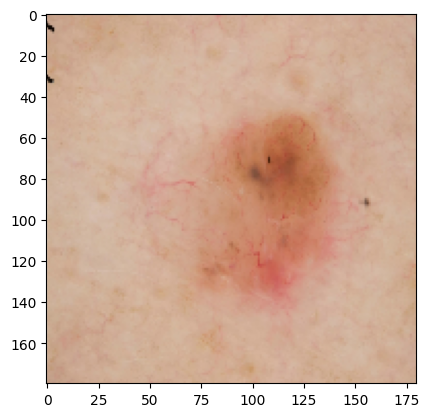

In [ ]:
# Evaluate the model
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-5],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )